# Transfer Learning Model Comparison for Plant Disease Classification
## Comparing 6 Pretrained Models with Performance Metrics + GFLOPs

## Cell 1: Install Required Libraries

In [1]:
# Install thop for GFLOP calculations
!pip install thop


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\josep\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


## Cell 2: Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from thop import profile
import matplotlib.pyplot as plt
import pandas as pd
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


## Cell 3: Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("="*60)
print("DEVICE CONFIGURATION")
print("="*60)
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("✅ GPU is ready!")
else:
    print("⚠️  WARNING: Running on CPU")
print("="*60)

DEVICE CONFIGURATION
Using device: cpu
⚠️  WARNING: Running on CPU


## Cell 4: Hyperparameters

In [4]:
# Hyperparameters
data_dir = "plant_dataset"
batch_size = 16
epochs = 5
learning_rate = 1e-4
weight_decay = 1e-4

print("Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")

Configuration:
  Batch size: 16
  Epochs: 5
  Learning rate: 0.0001
  Weight decay: 0.0001


## Cell 5: Load Dataset

In [5]:
# Dataset paths
train_dir = os.path.join(data_dir, "Train", "Train")
val_dir = os.path.join(data_dir, "Validation", "Validation")
test_dir = os.path.join(data_dir, "Test", "Test")

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)

print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Number of classes: {num_classes}")
print(f"\nTrain samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")
print("="*60)

DATASET INFORMATION
Number of classes: 3

Train samples: 1,322
Validation samples: 60
Test samples: 150

Train batches: 83
Val batches: 4
Test batches: 10


## Cell 6: Evaluation Function

In [6]:
def evaluate(model, loader):
    """Evaluate model and return metrics"""
    model.eval()
    preds, labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            p = torch.argmax(out, dim=1)
            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average="macro", zero_division=0),
        'recall': recall_score(labels, preds, average="macro", zero_division=0),
        'f1': f1_score(labels, preds, average="macro", zero_division=0)
    }

## Cell 7: Calculate Model GFLOPs

In [7]:
def calculate_gflops(model):
    """Calculate GFLOPs for a model"""
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops = 2 * macs
    gflops = flops / 1e9
    params_m = params / 1e6
    return gflops, params_m

## Cell 8: Training Function

In [8]:
def train_model(model, model_name):
    """Train a model and return metrics"""
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Training history
    history = {'train_loss': [], 'val_acc': []}
    
    # Start timer
    start_time = time.time()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(
            train_loader,
            desc=f"{model_name} Epoch [{epoch+1}/{epochs}]",
            leave=False
        )
        
        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        avg_loss = running_loss / len(train_loader)
        val_metrics = evaluate(model, val_loader)
        
        history['train_loss'].append(avg_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Loss: {avg_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f} | "
            f"Val F1: {val_metrics['f1']:.4f}"
        )
    
    # Training time
    training_time = time.time() - start_time
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader)
    
    # Calculate GFLOPs
    gflops, params = calculate_gflops(model)
    
    print(f"\n✅ {model_name} Training Complete!")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"GFLOPs: {gflops:.2f}")
    
    return {
        'model_name': model_name,
        'test_metrics': test_metrics,
        'gflops': gflops,
        'params': params,
        'training_time': training_time,
        'history': history
    }

## Cell 9: Define All Models

In [9]:
def create_models():
    """Create all 6 pretrained models"""
    models_dict = {}
    
    # 1. ResNet50
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
    models_dict['ResNet50'] = resnet50.to(device)
    
    # 2. MobileNetV2
    mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)
    models_dict['MobileNetV2'] = mobilenet.to(device)
    
    # 3. EfficientNet-B0
    efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)
    models_dict['EfficientNet-B0'] = efficientnet.to(device)
    
    # 4. DenseNet121
    densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
    models_dict['DenseNet121'] = densenet.to(device)
    
    # 5. VGG16
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)
    models_dict['VGG16'] = vgg.to(device)
    
    # 6. ConvNeXt Tiny
    convnext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    convnext.classifier[2] = nn.Linear(convnext.classifier[2].in_features, num_classes)
    models_dict['ConvNeXt-Tiny'] = convnext.to(device)
    
    return models_dict

# Create all models
print("Creating all pretrained models...")
all_models = create_models()

print("\n" + "="*60)
print("MODELS CREATED")
print("="*60)
for name, model in all_models.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"{name:20s} - {params:,} parameters")
print("="*60)

Creating all pretrained models...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:31<00:00, 3.30MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:05<00:00, 3.73MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:08<00:00, 3.74MB/s]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [02:41<00:00, 3.43MB/s] 



MODELS CREATED
ResNet50             - 23,514,179 parameters
MobileNetV2          - 2,227,715 parameters
EfficientNet-B0      - 4,011,391 parameters
DenseNet121          - 6,956,931 parameters
VGG16                - 134,272,835 parameters
ConvNeXt-Tiny        - 27,822,435 parameters


## Cell 10: Train All Models

In [10]:
# Train all models and collect results
results = []

for model_name, model in all_models.items():
    result = train_model(model, model_name)
    results.append(result)
    
    # Save model
    torch.save(model.state_dict(), f'{model_name.lower().replace("-", "_")}.pth')

print("\n" + "="*60)
print("ALL MODELS TRAINED AND SAVED!")
print("="*60)


TRAINING: ResNet50


ResNet50 Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.3647 | Val Acc: 1.0000 | Val F1: 1.0000


ResNet50 Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0643 | Val Acc: 1.0000 | Val F1: 1.0000


ResNet50 Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0242 | Val Acc: 1.0000 | Val F1: 1.0000


ResNet50 Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.0436 | Val Acc: 1.0000 | Val F1: 1.0000


ResNet50 Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0131 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ ResNet50 Training Complete!
Training Time: 1803.25s
Test Accuracy: 0.9800
GFLOPs: 8.26

TRAINING: MobileNetV2


MobileNetV2 Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.2209 | Val Acc: 1.0000 | Val F1: 1.0000


MobileNetV2 Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0418 | Val Acc: 1.0000 | Val F1: 1.0000


MobileNetV2 Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0307 | Val Acc: 1.0000 | Val F1: 1.0000


MobileNetV2 Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.0222 | Val Acc: 1.0000 | Val F1: 1.0000


MobileNetV2 Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0142 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ MobileNetV2 Training Complete!
Training Time: 616.76s
Test Accuracy: 0.9800
GFLOPs: 0.65

TRAINING: EfficientNet-B0


EfficientNet-B0 Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.4992 | Val Acc: 1.0000 | Val F1: 1.0000


EfficientNet-B0 Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0753 | Val Acc: 1.0000 | Val F1: 1.0000


EfficientNet-B0 Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0467 | Val Acc: 1.0000 | Val F1: 1.0000


EfficientNet-B0 Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.0372 | Val Acc: 1.0000 | Val F1: 1.0000


EfficientNet-B0 Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0277 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ EfficientNet-B0 Training Complete!
Training Time: 832.95s
Test Accuracy: 0.9800
GFLOPs: 0.83

TRAINING: DenseNet121


DenseNet121 Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.2481 | Val Acc: 1.0000 | Val F1: 1.0000


DenseNet121 Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0409 | Val Acc: 1.0000 | Val F1: 1.0000


DenseNet121 Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0289 | Val Acc: 1.0000 | Val F1: 1.0000


DenseNet121 Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.0174 | Val Acc: 1.0000 | Val F1: 1.0000


DenseNet121 Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0279 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ DenseNet121 Training Complete!
Training Time: 1673.18s
Test Accuracy: 0.9733
GFLOPs: 5.79

TRAINING: VGG16


VGG16 Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.1706 | Val Acc: 1.0000 | Val F1: 1.0000


VGG16 Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0499 | Val Acc: 1.0000 | Val F1: 1.0000


VGG16 Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0647 | Val Acc: 1.0000 | Val F1: 1.0000


VGG16 Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.1039 | Val Acc: 0.9833 | Val F1: 0.9833


VGG16 Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0486 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ VGG16 Training Complete!
Training Time: 4953.27s
Test Accuracy: 0.9667
GFLOPs: 30.93

TRAINING: ConvNeXt-Tiny


ConvNeXt-Tiny Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 | Loss: 0.1519 | Val Acc: 1.0000 | Val F1: 1.0000


ConvNeXt-Tiny Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 | Loss: 0.0120 | Val Acc: 1.0000 | Val F1: 1.0000


ConvNeXt-Tiny Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 | Loss: 0.0099 | Val Acc: 1.0000 | Val F1: 1.0000


ConvNeXt-Tiny Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 | Loss: 0.0033 | Val Acc: 1.0000 | Val F1: 1.0000


ConvNeXt-Tiny Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 | Loss: 0.0015 | Val Acc: 1.0000 | Val F1: 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ ConvNeXt-Tiny Training Complete!
Training Time: 731.89s
Test Accuracy: 0.9733
GFLOPs: 8.93

ALL MODELS TRAINED AND SAVED!


## Cell 11: Performance Comparison Table

In [11]:
# Create comparison DataFrame
comparison_data = {
    'Model': [r['model_name'] for r in results],
    'GFLOPs': [f"{r['gflops']:.2f}" for r in results],
    'Params (M)': [f"{r['params']:.2f}" for r in results],
    'Accuracy': [f"{r['test_metrics']['accuracy']:.4f}" for r in results],
    'Precision': [f"{r['test_metrics']['precision']:.4f}" for r in results],
    'Recall': [f"{r['test_metrics']['recall']:.4f}" for r in results],
    'F1-Score': [f"{r['test_metrics']['f1']:.4f}" for r in results],
    'Train Time (s)': [f"{r['training_time']:.2f}" for r in results]
}

df = pd.DataFrame(comparison_data)

# Sort by accuracy (descending)
df['Accuracy_float'] = df['Accuracy'].astype(float)
df = df.sort_values('Accuracy_float', ascending=False).drop('Accuracy_float', axis=1)
df = df.reset_index(drop=True)

print("\n" + "="*100)
print("TRANSFER LEARNING MODEL COMPARISON - PLANT DISEASE CLASSIFICATION")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# Save to CSV
df.to_csv('model_comparison.csv', index=False)
print("\n✅ Results saved to 'model_comparison.csv'")


TRANSFER LEARNING MODEL COMPARISON - PLANT DISEASE CLASSIFICATION
          Model GFLOPs Params (M) Accuracy Precision Recall F1-Score Train Time (s)
       ResNet50   8.26      23.51   0.9800    0.9811 0.9800   0.9800        1803.25
    MobileNetV2   0.65       2.23   0.9800    0.9804 0.9800   0.9800         616.76
EfficientNet-B0   0.83       4.01   0.9800    0.9804 0.9800   0.9800         832.95
    DenseNet121   5.79       6.96   0.9733    0.9753 0.9733   0.9735        1673.18
  ConvNeXt-Tiny   8.93      27.81   0.9733    0.9742 0.9733   0.9733         731.89
          VGG16  30.93     134.27   0.9667    0.9672 0.9667   0.9667        4953.27

✅ Results saved to 'model_comparison.csv'


## Cell 12: Visualize Performance Metrics

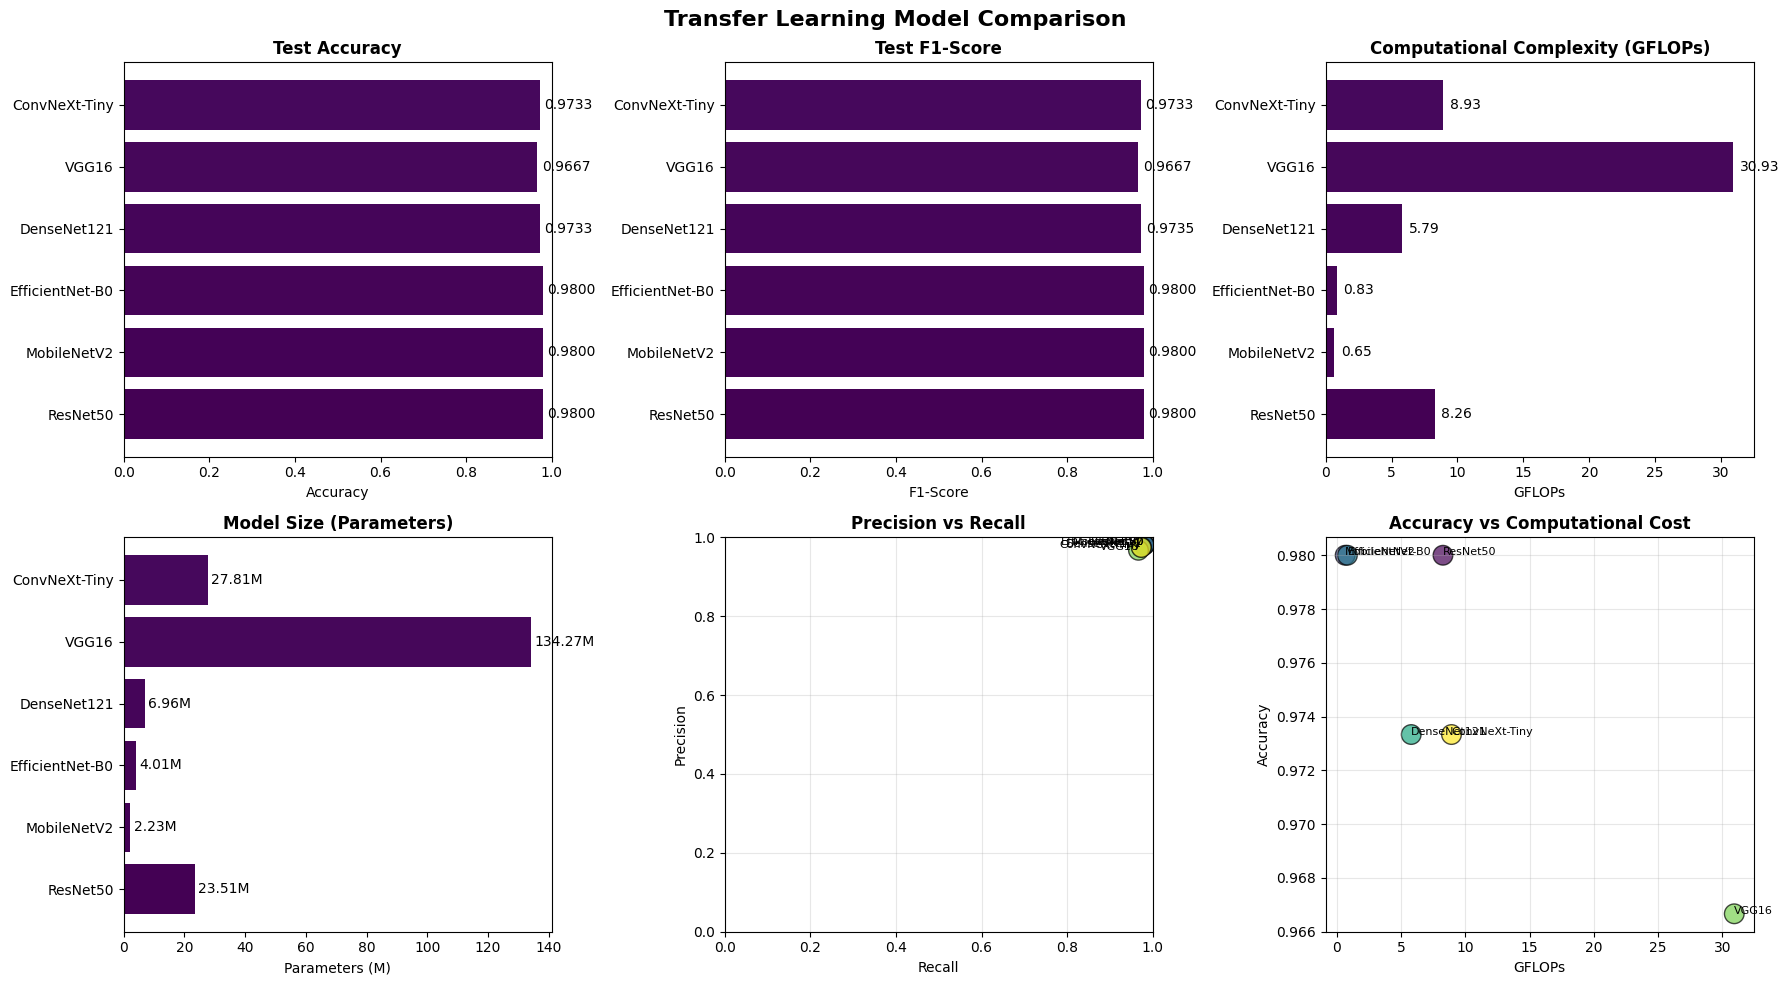

✅ Visualizations saved as 'model_comparison_visualizations.png'


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Transfer Learning Model Comparison', fontsize=16, fontweight='bold')

model_names = [r['model_name'] for r in results]
accuracies = [r['test_metrics']['accuracy'] for r in results]
precisions = [r['test_metrics']['precision'] for r in results]
recalls = [r['test_metrics']['recall'] for r in results]
f1_scores = [r['test_metrics']['f1'] for r in results]
gflops_list = [r['gflops'] for r in results]
params_list = [r['params'] for r in results]

colors = plt.cm.viridis(range(len(model_names)))

# 1. Accuracy
axes[0, 0].barh(model_names, accuracies, color=colors)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Test Accuracy', fontweight='bold')
axes[0, 0].set_xlim(0, 1)
for i, v in enumerate(accuracies):
    axes[0, 0].text(v + 0.01, i, f'{v:.4f}', va='center')

# 2. F1-Score
axes[0, 1].barh(model_names, f1_scores, color=colors)
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Test F1-Score', fontweight='bold')
axes[0, 1].set_xlim(0, 1)
for i, v in enumerate(f1_scores):
    axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center')

# 3. GFLOPs
axes[0, 2].barh(model_names, gflops_list, color=colors)
axes[0, 2].set_xlabel('GFLOPs')
axes[0, 2].set_title('Computational Complexity (GFLOPs)', fontweight='bold')
for i, v in enumerate(gflops_list):
    axes[0, 2].text(v + 0.5, i, f'{v:.2f}', va='center')

# 4. Parameters
axes[1, 0].barh(model_names, params_list, color=colors)
axes[1, 0].set_xlabel('Parameters (M)')
axes[1, 0].set_title('Model Size (Parameters)', fontweight='bold')
for i, v in enumerate(params_list):
    axes[1, 0].text(v + 1, i, f'{v:.2f}M', va='center')

# 5. Precision vs Recall
axes[1, 1].scatter(recalls, precisions, c=range(len(model_names)), cmap='viridis', s=200, alpha=0.7, edgecolors='black')
for i, name in enumerate(model_names):
    axes[1, 1].annotate(name, (recalls[i], precisions[i]), fontsize=8, ha='right')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision vs Recall', fontweight='bold')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

# 6. Accuracy vs GFLOPs (Efficiency)
axes[1, 2].scatter(gflops_list, accuracies, c=range(len(model_names)), cmap='viridis', s=200, alpha=0.7, edgecolors='black')
for i, name in enumerate(model_names):
    axes[1, 2].annotate(name, (gflops_list[i], accuracies[i]), fontsize=8, ha='left')
axes[1, 2].set_xlabel('GFLOPs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Accuracy vs Computational Cost', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved as 'model_comparison_visualizations.png'")

## Cell 13: Training History Comparison

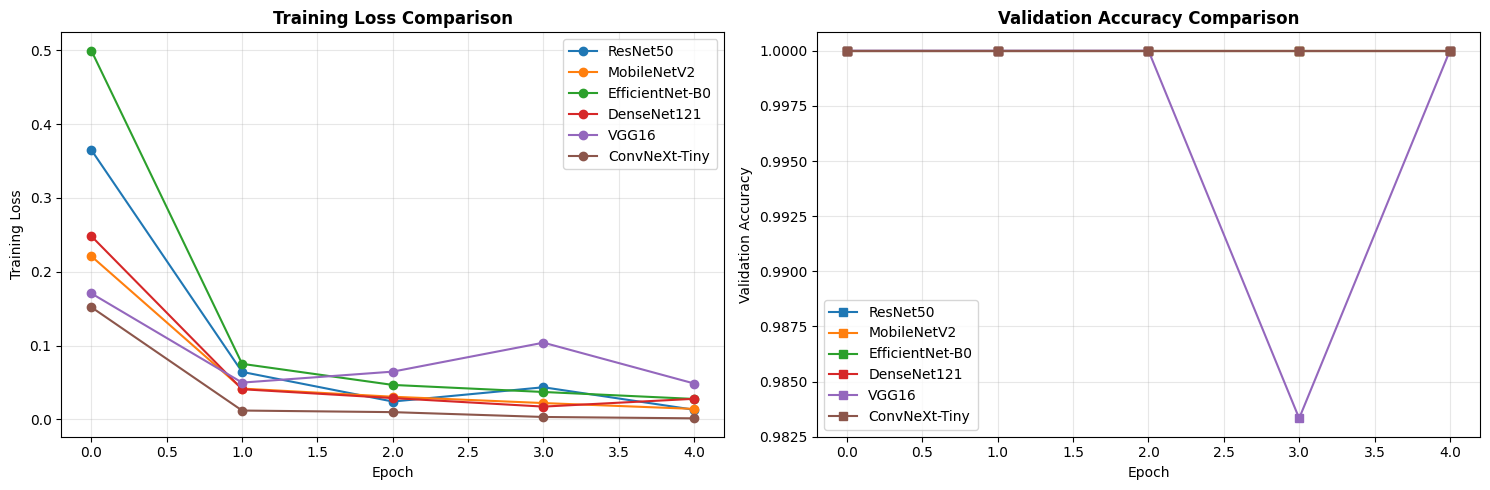

✅ Training history saved as 'training_history_comparison.png'


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
for result in results:
    ax1.plot(result['history']['train_loss'], label=result['model_name'], marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Accuracy
for result in results:
    ax2.plot(result['history']['val_acc'], label=result['model_name'], marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy Comparison', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history saved as 'training_history_comparison.png'")

## Cell 14: Best Model Analysis

In [14]:
# Find best models for different criteria
best_accuracy = max(results, key=lambda x: x['test_metrics']['accuracy'])
best_f1 = max(results, key=lambda x: x['test_metrics']['f1'])
most_efficient = min(results, key=lambda x: x['gflops'])
smallest_model = min(results, key=lambda x: x['params'])

# Calculate efficiency score (accuracy / GFLOPs)
efficiency_scores = [(r['model_name'], r['test_metrics']['accuracy'] / r['gflops']) for r in results]
best_efficiency = max(efficiency_scores, key=lambda x: x[1])

print("\n" + "="*60)
print("BEST MODEL ANALYSIS")
print("="*60)
print(f"\n🏆 Best Accuracy:")
print(f"   Model: {best_accuracy['model_name']}")
print(f"   Accuracy: {best_accuracy['test_metrics']['accuracy']:.4f}")
print(f"   F1-Score: {best_accuracy['test_metrics']['f1']:.4f}")
print(f"   GFLOPs: {best_accuracy['gflops']:.2f}")

print(f"\n📊 Best F1-Score:")
print(f"   Model: {best_f1['model_name']}")
print(f"   F1-Score: {best_f1['test_metrics']['f1']:.4f}")
print(f"   Accuracy: {best_f1['test_metrics']['accuracy']:.4f}")

print(f"\n⚡ Most Efficient (Lowest GFLOPs):")
print(f"   Model: {most_efficient['model_name']}")
print(f"   GFLOPs: {most_efficient['gflops']:.2f}")
print(f"   Accuracy: {most_efficient['test_metrics']['accuracy']:.4f}")

print(f"\n💾 Smallest Model (Fewest Parameters):")
print(f"   Model: {smallest_model['model_name']}")
print(f"   Parameters: {smallest_model['params']:.2f}M")
print(f"   Accuracy: {smallest_model['test_metrics']['accuracy']:.4f}")

print(f"\n🎯 Best Efficiency Score (Accuracy/GFLOPs):")
print(f"   Model: {best_efficiency[0]}")
print(f"   Efficiency Score: {best_efficiency[1]:.6f}")

print("\n" + "="*60)

# Recommendations
print("\n📋 RECOMMENDATIONS:")
print("="*60)
print(f"For highest accuracy: Use {best_accuracy['model_name']}")
print(f"For mobile/edge deployment: Use {most_efficient['model_name']}")
print(f"For best balance: Use {best_efficiency[0]}")
print("="*60)


BEST MODEL ANALYSIS

🏆 Best Accuracy:
   Model: ResNet50
   Accuracy: 0.9800
   F1-Score: 0.9800
   GFLOPs: 8.26

📊 Best F1-Score:
   Model: MobileNetV2
   F1-Score: 0.9800
   Accuracy: 0.9800

⚡ Most Efficient (Lowest GFLOPs):
   Model: MobileNetV2
   GFLOPs: 0.65
   Accuracy: 0.9800

💾 Smallest Model (Fewest Parameters):
   Model: MobileNetV2
   Parameters: 2.23M
   Accuracy: 0.9800

🎯 Best Efficiency Score (Accuracy/GFLOPs):
   Model: MobileNetV2
   Efficiency Score: 1.502097


📋 RECOMMENDATIONS:
For highest accuracy: Use ResNet50
For mobile/edge deployment: Use MobileNetV2
For best balance: Use MobileNetV2


## Cell 15: Summary Statistics

In [15]:
# Calculate summary statistics
accuracies = [r['test_metrics']['accuracy'] for r in results]
gflops_all = [r['gflops'] for r in results]
params_all = [r['params'] for r in results]
times_all = [r['training_time'] for r in results]

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nAccuracy:")
print(f"  Mean: {sum(accuracies)/len(accuracies):.4f}")
print(f"  Min:  {min(accuracies):.4f}")
print(f"  Max:  {max(accuracies):.4f}")
print(f"  Std:  {(sum([(x - sum(accuracies)/len(accuracies))**2 for x in accuracies])/len(accuracies))**0.5:.4f}")

print(f"\nGFLOPs:")
print(f"  Mean: {sum(gflops_all)/len(gflops_all):.2f}")
print(f"  Min:  {min(gflops_all):.2f}")
print(f"  Max:  {max(gflops_all):.2f}")

print(f"\nParameters (M):")
print(f"  Mean: {sum(params_all)/len(params_all):.2f}")
print(f"  Min:  {min(params_all):.2f}")
print(f"  Max:  {max(params_all):.2f}")

print(f"\nTraining Time (s):")
print(f"  Mean: {sum(times_all)/len(times_all):.2f}")
print(f"  Min:  {min(times_all):.2f}")
print(f"  Max:  {max(times_all):.2f}")

print("="*60)


SUMMARY STATISTICS

Accuracy:
  Mean: 0.9756
  Min:  0.9667
  Max:  0.9800
  Std:  0.0050

GFLOPs:
  Mean: 9.23
  Min:  0.65
  Max:  30.93

Parameters (M):
  Mean: 33.13
  Min:  2.23
  Max:  134.27

Training Time (s):
  Mean: 1768.55
  Min:  616.76
  Max:  4953.27
